# Data 558 Final Project: Code Part 1
**Including and building off of Homework 4 and 5 suggested exercises**  
Alyssa Goodrich   
June 4, 2017


In [1]:
#Load necessary packages
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import math
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from IPython.core.debugger import Tracer
from sklearn.model_selection import StratifiedShuffleSplit



In [3]:
data = pd.read_csv('https://s3.amazonaws.com/data558ag/Project/features.csv', sep=',', header=None)
labels = pd.read_csv('https://s3.amazonaws.com/data558ag/Project/labels.csv', sep=',', header=None)
testFeatures = pd.read_csv('https://s3.amazonaws.com/data558ag/Project/testFeatures.csv', sep=',', header=None)
testLabels = pd.read_csv('https://s3.amazonaws.com/data558ag/Project/testLabels.csv', sep=',', header=None, dtype = int)
testLabels = np.array(testLabels)[:,0]
dataLabels = pd.read_csv('https://s3.amazonaws.com/data558ag/Project/DataLabels.csv', sep=',', header=None)
dataLabels = np.array(dataLabels)
# data = pd.read_csv('../Project/features.csv', sep=',', header=None)
# labels = pd.read_csv('../Project/labels.csv', sep=',', header=None)

y = labels
y = np.array(y)
x = data
Cats, y = np.unique(y, return_inverse = True)
# ySub = (y <10) #Toggle for faster computations when writing and testing algorithms
# x= x[ySub]
# y = y[ySub]
xMean = np.mean(x, axis = 0)
xStd = np.std(x, axis = 0)
testFeatures = (testFeatures - xMean)/xStd
x = (x - np.mean(x, axis =0))/(np.std(x,axis = 0))
x = np.array(x)

#Thanks to scikit learn documentation for demonstrating this way to extract a training set with same proportions of samples in test and train set as in original data 
def splitTestTrain(x, y, testPCT, numSplits):
    sss = StratifiedShuffleSplit(n_splits=numSplits, test_size=testPCT, random_state=0)
    for train_index, test_index in sss.split(x,y):
        xTrain, xTest = x[train_index], x[test_index]
        yTrain, yTest = y[train_index], y[test_index]
        return (xTrain, xTest,yTrain, yTest)

xTrain, xTest,yTrain, yTest = splitTestTrain(x,y,.2, 1)
beta_init = np.zeros(x.shape[1])
testingBetas = np.random.randint(-50,50, size = x.shape[1])/50

def predstoFile(preds, filename):
    newpreds = convertY(preds, Cats, dataLabels) #Converts predictions using my labels to predictions with the standard labels
    LabsPreds = np.stack((testLabels,newpreds)).T # links predictions to corresponding image label
    LabsPreds = LabsPreds.astype(int) #converts to integer type for sorting
    LabsPreds = LabsPreds[np.argsort(LabsPreds[:, 0])]
    names = np.array(['Id', 'Prediction'])
    LabsPreds = np.vstack((names, LabsPreds))
    np.savetxt(filename, LabsPreds, delimiter = ",", fmt='%s')
    return

def convertY(preds, Cats = Cats, labels = dataLabels):
    #preds is my predictions based on my categories
    #Cats is the link back to the name of the bird from my category
    #Labels is the correct bird / number mapping as defined by the contest organizer
    namePreds = Cats[preds]
    numPreds = ()
    namPredsCheck = ()
    
    for i in range(len(preds)):
        newCatPred = labels[np.where(labels[:,1] == Cats[preds][i])[0],0]  
        newNamePred = labels[np.where(labels[:,1] == Cats[preds][i])[0],1]
        #print(i,newCatPred,newNamePred)
        numPreds = np.append(numPreds, newCatPred)
        namPredsCheck = np.append(namPredsCheck, newNamePred)
    return(numPreds)


In [4]:
def computegrad(lam,betas, y=yTrain, x= xTrain): #Thanks to Rajiv for explaining this
    n = len(x)
    xdotb = x.dot(betas)
    denom = 1/( 1+np.exp( y*xdotb ))
    grad=-x.T.dot(y*denom)
    grad = (grad/n)+lam*2*betas
    return(grad)
# def computegrad(betas , lam , x=xTrain , y=yTrain): 
#     yx = y[:, np.newaxis]*x 
#     denom = 1+np.exp(-yx.dot(betas)) 
#     grad = 1/len(y)*np.sum(-yx*np.exp(-yx.dot(betas[:,np.newaxis]))/denom[:,np.newaxis] , axis=0) + 2 *lam*betas
#     return grad

In [5]:
def objfunc(lam, y, x, betas):
    obj = (np.sum(np.log(1+np.exp(-y*x.dot(betas)))))/x.shape[0] + lam * np.linalg.norm(betas)**2
    return(obj)

In [6]:
#Initialize Backtracking function
def backtracking(lam, betas,x, y, t = 10, alpha = 0.5, gamma = 0.8, maxIter = 100):
    # f = objective function
    # grad = gradient function
    # betas = current point
    # t = starting step size
    # alpha = constant used to define sufficient decrease condition
    # gamma = fraction by which we drecrease t if the previous T doesn't work
    # maxIter = maximume iterations for algorithm
    #output = t, the step size to use
    # Set inital step size. What is it See page 25 in week 3 notes?
    grad_b = computegrad(betas = betas, lam = lam , x=x, y=y)
    norm_grad_b = np.linalg.norm(grad_b)
    found_t = 0
    iters = 0
    t = deepcopy(t)
    while found_t == 0 and iters < maxIter:
        if objfunc(betas = (betas-t*grad_b), lam = lam, x=x, y=y) < objfunc(betas = betas, lam = lam , x=x , y=y)-alpha*t*norm_grad_b**2:
            found_t = 1 
        else:
            t *= gamma
            iters += 1
            #print("t =:",str(t), "lhs =:", str(lhs), "rhs =", str(rhs))

    return(t)

In [7]:
from scipy.linalg import eigh as largest_eigh
#Caluclate initial step size (page 28 in week 3 notes)
def calcStepInit (x = xTrain, y = yTrain, lam = 1):
    n = x.shape[0]
    n1 =  x.shape[1]
    MaxEigVal = largest_eigh(np.dot(1/n*x.T, x), eigvals= (n1-1, n1-1))[0]
    L = MaxEigVal + lam
    StepInit = (1/(MaxEigVal + lam))
    StepInit = float(StepInit)
    return(StepInit)
StepInit = calcStepInit()

In [8]:
def fastgradalgo(betas, theta, step, x,  y, lam, maxIter = 1000):

    # betas = initial beta
    # theta = initial theta
    # alpha = constant used to define sufficient decrease condition
    # beta = fraction by which we drecrease t if the previous T doesn't work
    # maxIter = maximume iterations for algorithm
    # output = series of betas, the step size to use
    theta = np.zeros(xTrain.shape[1])
    b_vals = [betas]
    for i in range(0,maxIter):
        step = backtracking(betas = betas, t = step, lam = lam, x = xTrain, y = yTrain)
        #print("i =", i)
        #print("step =", step)
        betaNew = theta - step*computegrad(betas = theta, lam = lam, x = x, y = y)
        #print(b)
        b_vals.append(betaNew) 
        #print(b_vals)
        theta = betaNew+ (i/(i+3))*(betaNew - betas)
        betas = betaNew
    return(b_vals)

In [11]:
#compute optimal betas
myLam = 1
fgBetas = fastgradalgo(betas = beta_init, theta = beta_init,step = StepInit, x = xTrain, y=yTrain,lam = myLam,  maxIter = 1000)

In [9]:
#create function to calculate objective values for array of betas
def calcObjVal(betas, lam, x, y):
    objVals = []
    for i in range(0,len(betas)):
        objVals.append(objfunc(betas = betas[i], lam = lam, x = x, y = y))
    return(objVals)


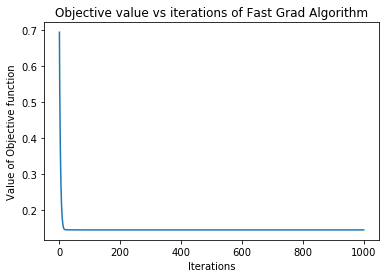

In [90]:
fgObjVals = calcObjVal(betas = fgBetas, lam = 1, x = xTrain, y = yTrain)
%matplotlib inline
plt.plot(range(len(fgObjVals)), fgObjVals, label = "Fast Grad Algo")
plt.xlabel("Iterations")
plt.ylabel("Value of Objective function")

plt.title("Objective value vs iterations of Fast Grad Algorithm")


In [10]:
def class_error (betaStar, x , y): 
    pred = 1/(1+np.exp(-x.dot(betaStar))) > 0.5 
    pred = pred*2- 1 # Convert to +/− 1 
    error = np.mean(pred !=y)
    return error

In [11]:
def class_error_array(betas, x, y):
    n = len(betas)
    errors = ()
    for i in range(n):
        error = class_error(betas[i], x, y)
        errors = np.append(errors, error)
    return(errors)

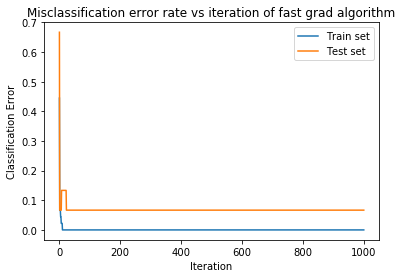

In [13]:
TrainErrors = class_error_array(betas = fgBetas, x= xTrain, y = yTrain)
TestErrors = class_error_array(betas = fgBetas, x= xTest, y = yTest)

plt.plot(TrainErrors,label = "Train set")
plt.plot(TestErrors, label = "Test set")
plt.legend(loc = "upper right")
plt.title("Misclassification error rate vs iteration of fast grad algorithm")
plt.xlabel("Iteration")
plt.ylabel("Classification Error")

**Bullet 2**  
Find the value of the regularization parameter λ using cross-validation; you may use
scikit-learn’s built-in functions for this purpose. Train an L2-regularized logistic regression classifier on the training set using your own fast gradient algorithm with that value of λ found by cross-validation. Plot, with different colors, the misclassification error on the training set and on the validation set vs iterations.

The optimal lambda for cross validation is: 0.00075


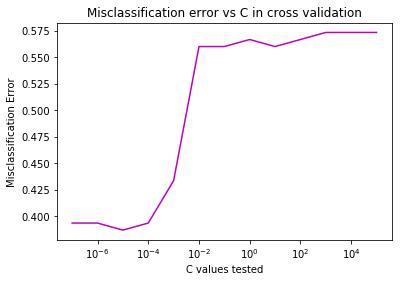

In [51]:
cs = (.0000001, .000001,.00001, .0001,.001, .01, .1, 1, 10, 100, 1000, 10000, 100000)
MyLogCV = LogisticRegressionCV(penalty='l2', Cs = cs, fit_intercept=False, tol=10e-8, max_iter=1000) 
MyLogCV.fit(x , y) 
BestLam = MyLogCV.C_[0] 
AdjLam = 1/(BestLam*2*x.shape[0])
AdjLam = (BestLam*x.shape[0]/2)

print("The optimal lambda for cross validation is:",AdjLam)
coeff = MyLogCV.coef_==0
errors = 1- (np.mean(MyLogCV.scores_[9], axis = 0))

fig, ax = plt.subplots()
ax.plot(cs,errors, 'm-')
plt.xlabel('C values tested')
plt.ylabel('Misclassification Error')
plt.title('Misclassification error vs C in cross validation')

ax.plot()
plt.xscale('log')

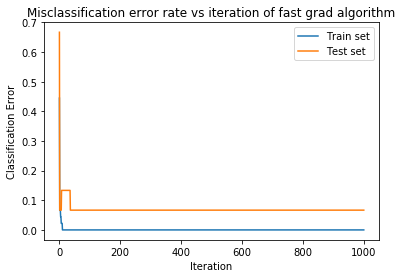

In [16]:
myLam = AdjLam
fgBetas = fastgradalgo(betas = beta_init, theta = beta_init, x = xTrain, y = yTrain, step = StepInit, maxIter = 1000, lam = myLam)
TrainErrors = class_error_array(betas = fgBetas, x= xTrain, y = yTrain)
TestErrors = class_error_array(betas = fgBetas, x= xTest, y = yTest)
plt.plot(TrainErrors,label = "Train set")
plt.plot(TestErrors, label = "Test set")
plt.legend(loc = "upper right")
plt.title("Misclassification error rate vs iteration of fast grad algorithm")
plt.xlabel("Iteration")
plt.ylabel("Classification Error")


**HW5 Bullet 1**  
Pick k = 5 classes of your choice from the dataset. You may choose any subset of 5 classes among all classes of the dataset.

In [15]:

y = labels
y = np.array(y)
x = data
Cats, y = np.unique(y, return_inverse = True)
ySub = ((y == 139) + (y == 138)+(y == 137) + (y == 136)+(y == 135))
x= x[ySub]
y = y[ySub]
x = (x - np.mean(x, axis =0))/(np.std(x,axis = 0))
x = np.array(x)

from sklearn.model_selection import StratifiedShuffleSplit
def splitTestTrain(x, y, testPCT, numSplits):
    sss = StratifiedShuffleSplit(n_splits=numSplits, test_size=testPCT, random_state=0)
    for train_index, test_index in sss.split(x,y):
        xTrain, xTest = x[train_index], x[test_index]
        yTrain, yTest = y[train_index], y[test_index]
        return (xTrain, xTest,yTrain, yTest)

xTrain, xTest,yTrain, yTest = splitTestTrain(x,y,.2, 1)
beta_init = np.zeros(x.shape[1])
testingBetas = np.random.randint(-50,50, size = x.shape[1])/50


**HW5 Bullet 2**  
Write a function that, for any class at hand, creates a training set with an equal number of examples from the class at hand and from the other classes. You may simply randomly pick the examples from the other classes. 

In [12]:
def subset_data(x, y, c, trainPCT):
    #x is the dataset with features
    #y is the dataset with labels
    #C is the category that was chosen
    #trainPCT is the percent of the dataset you want to be training data
    if sum(y == c) == 0: 
            raise ('Category selected does not exist in this data') 
    else:
        ysubc = (y==c)
        notc = [not i for i in ysubc]
        yc, xc, ynotc, xnotc = y[ysubc], x[ysubc], y[notc], x[notc]
        n = round(len(yc) * trainPCT) #Lenght of training set
        nt =len(yc) - n #length of test set
        cSelector = (np.append([[True]*n], [(len(yc)-n)*[False]]))
        notCSelector = (np.append([[True]*n], [(len(ynotc)-n)*[False]]))
        np.random.shuffle(cSelector)
        np.random.shuffle(notCSelector)

        yTrain = np.append([yc[cSelector]],[ynotc[notCSelector]])
        yTrainBin = deepcopy(yTrain)
        yTrainBin[yTrain!=c], yTrainBin[yTrain==c] = -1, 1
        
        xTrain = np.vstack((xc[cSelector],xnotc[notCSelector]))
        yTest = np.append([yc[~cSelector]],[ynotc[notCSelector][:nt]])
        yTestBin = deepcopy(yTest)
        yTestBin[yTestBin!=c], yTestBin[yTestBin==c] = -1, 1

        xTest = np.vstack((xc[~cSelector],xnotc[notCSelector][:nt,:]))

    return(xTrain, yTrain,yTrainBin, xTest, yTest, yTestBin)

**HW5 Bullet 3**  
For each class c, train an L2-regularized logistic regression classiﬁer using your own fast gradient algorithm with λc = 1. Display the confusion matrix. Which classes seem to be the most diﬃcult to classify?

In [13]:
def confusionMatrix(x, y, lam, trainPCT = .75):
    Cs = np.unique(y)
    nt =int(len(y)/len(Cs) - round(len(y)/len(Cs) * trainPCT))*2 #length of test set 
    ConfMat = np.zeros((len(Cs),len(Cs))) #initialize repository for confidence matrix
    #initialize dictionaries to store the data sets 
    Preds = np.zeros((len(y), len(Cs)))

    myBetas={}
    for i in range(len(Cs)):
        c = Cs[i]
        #ConfMat[0,i] = c #label axes of confusion matrix
        #ConfMat[i,0] = c
 
        #generate data
        xTrainTemp, yTrainTemp,yTrainBinTemp, xTestTemp, yTestTemp, yTestBinTemp = subset_data(x = x, y = y, c = c, trainPCT = trainPCT)
        
        #Calculate step size
        stepInit = calcStepInit (x = xTrainTemp, y = yTrainTemp, lam = lam)
       
        #Train model
        myBetas[c] = fastgradalgo(x=xTrainTemp, y = yTrainBinTemp, betas = np.zeros(x.shape[1]), theta = np.zeros(x.shape[1]),  step = stepInit, lam = lam, maxIter = 100)[-1]
    
    #Find the prediction using each set of betas
    for i in range(len(Cs)):
        c = Cs[i]
        #Find predictions for our test set
        pred = 1/(1+np.exp(-x.dot(myBetas[c]))) 
        Preds[:,i] =deepcopy(pred) #Capture predictions for each run through data
   
    #Select prediction with highest probability and create the confusion matrix
    MaxProbIndex = np.argmax(Preds, axis = 1)
    for k in range(len(y)):
        column = MaxProbIndex[k]
        row = np.where(Cs == y[k])[0]
        ConfMat[row, column] = ConfMat[row, column] + 1
            #ConfMat[np.where(Cs == Preds[k])[0],np.where(Cs == YTest[k])[0]] = ConfMat[np.where(Cs == Preds[k])[0],np.where(Cs == YTest[k])[0]]+ 1
    
    ConfMat = pd.DataFrame(data=ConfMat, index=Cs, columns=Cs)
    preds = Cs[MaxProbIndex]
    MultiClassError = np.mean(preds != y)
    return (ConfMat, preds, MultiClassError)


In [22]:
CMat, Preds, Error=confusionMatrix(x=x, y=y, lam=1, trainPCT = .75)
print(CMat)
print(Preds)
print(Error)

      135   136   137   138   139
135  30.0   0.0   0.0   0.0   0.0
136   0.0  29.0   1.0   0.0   0.0
137   0.0   1.0  29.0   0.0   0.0
138   0.0   0.0   0.0  30.0   0.0
139   0.0   0.0   0.0   0.0  30.0
[139 139 136 138 136 136 138 138 138 139 135 138 135 137 138 136 137 139
 138 139 139 137 136 137 139 139 137 135 139 135 135 135 139 135 135 137
 137 135 139 136 135 138 135 136 137 136 139 137 138 138 139 135 139 137
 135 136 137 136 135 135 137 137 135 137 139 138 138 136 136 136 135 137
 136 138 136 135 136 138 139 138 136 138 137 137 135 137 139 138 138 137
 135 136 139 137 138 139 136 136 139 138 139 138 135 135 137 139 137 139
 137 136 137 136 137 138 138 138 136 137 137 139 135 137 138 138 139 135
 135 136 138 138 137 139 139 136 135 135 139 136 136 138 137 135 139 136
 138 135 136 135 139 136]
0.0133333333333


**HW5 Bullet 4**  
Write a function that returns the ranked list of classes in terms of classiﬁcation diﬃculty using the confusion matrix. Compute the multi-class misclassiﬁcation error. 

In [14]:
def classDiff(CM):
    #CM = confusion matrix
    #DataFrame.sum(axis=None, skipna=None, level=None, numeric_only=None, **kwargs)
    size = CM.shape[0]
    difficulty = pd.DataFrame.sum(CM, axis = 0)
    for i in range(0,size):
        difficulty.iloc[i] = difficulty.iloc[i] - CM.iloc[i,i]
    difficulty.sort_values(inplace = True, ascending = False)
    MisClassError = np.sum(difficulty.sum())/np.sum(CM.sum())
    return(difficulty, MisClassError)

In [24]:
a, b = classDiff(CMat)
print(a)
print(b)

137    1.0
136    1.0
139    0.0
138    0.0
135    0.0
dtype: float64
0.0133333333333


**HW5 Bullet 5**  
Find the values of the regularization parameters λ1,...,λk for the classiﬁers using a hold-out validation set strategy. Deﬁne a grid of values Λ for each parameter λc with c = 1,...,k. For each setting of the regularization parameters λ1,...,λk, where each λc can take values in Λ (independently), train all your k = 5 classiﬁers and save the multi-class misclassiﬁcation error on the validation set for each setting of the regularization parameters λ1,...,λk. 

In [15]:
y = labels
y = np.array(y)
x = data
Cats, y = np.unique(y, return_inverse = True)
Bird = 'Wren' # choose a species of bird with several subspecies
Indices = [i for i, v in enumerate(Cats) if Bird in v] #Find indices that include species of bird
Indices = Indices[0:5]
ySub = ((y == Indices[0])+ (y == Indices[1])+(y == Indices[2])+ (y == Indices[3])+(y == Indices[4]))
x= x[ySub]
y = y[ySub]
x = (x - np.mean(x, axis =0))/(np.std(x,axis = 0))
x = np.array(x)
xTrain, xTest,yTrain, yTest = splitTestTrain(x,y,.2, 1)
beta_init = np.zeros(x.shape[1])
testingBetas = np.random.randint(-50,50, size = x.shape[1])/50

In [16]:
#This data subset assumes test and train have already been split out
def subset_data2(x, y, c):
    #x is the dataset with features
    #y is the dataset with labels
    #C is the category that was chosen
    if sum(y == c) == 0: 
            raise ('Category selected does not exist in this data') 
    else:
        ysubc = (y==c)
        notc = [not i for i in ysubc]
        yc, xc, ynotc, xnotc = y[ysubc], x[ysubc], y[notc], x[notc]
        n = len(yc) #Lenght of things to select from the not c set
        notCSelector = (np.append([[True]*n], [(len(ynotc)-n)*[False]]))
        np.random.shuffle(notCSelector)

        yTemp = np.append([yc],[ynotc[notCSelector]])
        yTempBin = deepcopy(yTemp)
        yTempBin[yTemp!=c], yTempBin[yTemp==c] = -1, 1
        
        xTemp = np.vstack((xc,xnotc[notCSelector]))
       
    return(xTemp, yTemp,yTempBin)

In [17]:
#Initialize a function that returns a probability of c or not c for each image, given a category c and each value of lambda

def findprobs(c, lambdas, x = xTrain, y = yTrain, xTest = xTest):
    nt =len(yTest) #length of test set 
    Preds = np.zeros((len(lambdas), nt))
    myBetas={}
    
    #generate data
    xTemp, yTemp,yTempBin = subset_data2(x = x, y = y, c = c)
        
    #Calculate step size
       
    for i in range(len(lambdas)):
        lam = lambdas[i]
        stepInit = calcStepInit (x = xTemp, y = yTemp, lam = lam)

  
        #Train model
        myBetas = fastgradalgo(x=xTemp, y = yTempBin, betas = np.zeros(x.shape[1]), theta = np.zeros(x.shape[1]),  step = stepInit, lam = lam, maxIter = 100)[-1]
    
        pred = 1/(1+np.exp(-xTest.dot(myBetas))) 
        Preds[i,:] = pred
    return(Preds)
     
        


In [18]:
lams = np.array((.001, .01, .1, 1, 10, 100, 1000))

def findOptLams(xTest = xTest, yTest = yTest, xTrain = xTrain, yTrain = yTrain, lambdas = lams):
    #Initialize variables we will use in the function
    nLams = len(lams)
    Cs = np.unique(y)
    Probs = np.zeros((len(Cs,), nLams, len(yTest))) # repository to store all predicted probabilities
    TempProbs = np.zeros((len(yTest), len(Cs,))) # repository to store temprorary probabilities for comparison using each combindation of lambdas
    columns = ('C1 Lamda','C2 Lamda','C3 Lamda','C4 Lamda','C5 Lamda','Error')
    ErrorTrack = pd.DataFrame(columns = columns)
    yCats = np.unique(yTest)
    #fit models and create predictions  probabilities for 
    for i in range(len(Cs)):
        c = Cs[i]
        CProbs = findprobs(c = c, lambdas = lambdas, x = xTrain, y = yTrain, xTest = xTest) # Create predicted probabilities using 1vr for each category using each lambda
        Probs[i,:,:] = CProbs
    
    # find prediction for each level of lambda in each category
    for i in range(nLams):
        c1 = Cs[0]
        lam1 = lambdas[i]
        TempProbs[:, 0] = deepcopy(Probs[0, i, :])
        for j in range(nLams):
            c2 = Cs[1]
            lam2 = lambdas[j]
            TempProbs[:, 1] = deepcopy(Probs[1, j, :])
            for k in range(nLams):
                c3 = Cs[2]
                lam3 = lambdas[k]
                TempProbs[:, 2] = deepcopy(Probs[2, k, :])            
                for l in range(nLams):
                    c4 = Cs[3]
                    lam4 = lambdas[l]
                    TempProbs[:, 3] = deepcopy(Probs[3, l, :])
                    for m in range(nLams):
                        c5 = Cs[4]
                        lam5 = lambdas[m]
                        TempProbs[:, 4] = deepcopy(Probs[4, m, :])
                        MaxProbIndex = np.argmax(TempProbs, axis = 1)
                        Pred = yCats[MaxProbIndex]
                        #print("Pred:", Pred, "YTest:", yTest )
                        Error = 1 - np.mean(Pred == yTest)
                        tempError = pd.DataFrame([[lam1, lam2, lam3, lam4, lam5, Error]], columns = columns)
                        ErrorTrack = ErrorTrack.append(tempError)#            
    return(ErrorTrack)

In [54]:
#Show all combinations of lambda that minmize the misclassification error
AllLams = findOptLams(xTest = xTest, yTest = yTest, xTrain = xTrain, yTrain = yTrain, lambdas = lams)
MinError = AllLams.min(axis=0).iloc[5]
OptLams = AllLams.loc[AllLams['Error'] == MinError]
OptLams

C:\Users\Alyssa\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


,C1 Lamda,C2 Lamda,C3 Lamda,C4 Lamda,C5 Lamda,Error
0,100.0,0.001,0.001,0.001,100.0,0.210526
0,100.0,0.001,0.001,0.010,100.0,0.210526
0,100.0,0.001,0.001,0.100,100.0,0.210526
0,100.0,0.001,0.001,1.000,100.0,0.210526
0,100.0,0.001,0.001,10.000,100.0,0.210526
0,100.0,0.001,0.010,0.001,100.0,0.210526
0,100.0,0.001,0.010,0.010,100.0,0.210526
0,100.0,0.001,0.010,0.100,100.0,0.210526
0,100.0,0.001,0.010,1.000,100.0,0.210526
0,100.0,0.001,0.010,10.000,100.0,0.210526


**HW5 Bullet 6**  
Find the optimal value of the regularization parameters λ1,...,λk based on the validation error. Display the confusion matrix for this setting of the regularization parameters.

In [285]:
np.array(OptLams.iloc[-1, :5])

array([ 100.,   10.,  100.,  100.,  100.])

In [56]:
# Define a function to find predictions for a given category c and a given lambda l
def findprobsOneLam(c, lam, x = xTrain, y = yTrain, xTest = xTest):
    nt =len(yTest) #length of test set 
    myBetas={}
    
    #generate data
    xTemp, yTemp,yTempBin = subset_data2(x = x, y = y, c = c)
        
    #Calculate step size
       
    stepInit = calcStepInit (x = xTemp, y = yTemp, lam = lam)

  
        #Train model
    myBetas = fastgradalgo(x=xTemp, y = yTempBin, betas = np.zeros(x.shape[1]), theta = np.zeros(x.shape[1]),  step = stepInit, lam = lam, maxIter = 100)[-1]
    
    pred = 1/(1+np.exp(-xTest.dot(myBetas))) 
    return(pred)


In [57]:
#Create a confusion matrix with optimal lambdas
myOptLams = np.array(OptLams.iloc[-1, :5])

def OptLamConfMat(xTest = xTest, yTest = yTest, xTrain = xTrain, yTrain = yTrain, Lams = myOptLams):
    #Initialize variables we will use in the function
    #Lams is an array of lambdas of length of the number of categories where each entry is the optimal lambda for a category (listed in same order as category)
    nLams = len(Lams)
    Cs = np.unique(y)
    Probs = np.zeros((len(yTest), len(Cs,))) # repository to store all predicted probabilities
    yCats = np.unique(yTest)
    ConfMat = np.zeros((len(Cs),len(Cs))) #initialize repository for confidence matrix

    #fit models and create predictions  probabilities for 
    for i in range(len(Cs)):
        c = Cs[i]
        lam = Lams[i]
        CProbs = findprobsOneLam(c = c, lam = lam, x = xTrain, y = yTrain, xTest = xTest) # Create predicted probabilities using 1vr for each category using each lambda
        Probs[:,i] = CProbs
        
    MaxProbIndex = np.argmax(Probs, axis = 1)
    for k in range(len(yTest)):
        column = MaxProbIndex[k]
        row = np.where(Cs == yTest[k])[0]
        ConfMat[row, column] = ConfMat[row, column] + 1
            #ConfMat[np.where(Cs == Preds[k])[0],np.where(Cs == YTest[k])[0]] = ConfMat[np.where(Cs == Preds[k])[0],np.where(Cs == YTest[k])[0]]+ 1
#     ConfMat = pd.DataFrame(data=ConfMat, index=Cats[Cs], columns=Cats[Cs])
    preds = Cs[MaxProbIndex]
    MultiClassError = np.mean(preds != yTest)
    return(ConfMat, MultiClassError,preds)

In [317]:
OptLamConfMat(xTest = xTest, yTest = yTest, xTrain = xTrain, yTrain = yTrain, Lams = myOptLams)

,Bewick_Wren,Cactus_Wren,Carolina_Wren,Marsh_Wren,Rock_Wren
Bewick_Wren,5.0,0.0,1.0,0.0,0.0
Cactus_Wren,1.0,5.0,0.0,0.0,0.0
Carolina_Wren,1.0,0.0,5.0,0.0,0.0
Marsh_Wren,1.0,0.0,1.0,4.0,0.0
Rock_Wren,1.0,0.0,1.0,0.0,4.0


**Extending my one vs rest from five categories to all categories**

In [201]:
#Redefine x and y as my whole dataset
y = labels
y = np.array(y)
x = data
Cats, y = np.unique(y, return_inverse = True)
x = (x - np.mean(x, axis =0))/(np.std(x,axis = 0))
x = np.array(x)
xTrain, xTest,yTrain, yTest = splitTestTrain(x,y,.2, 1)
beta_init = np.zeros(x.shape[1])
testingBetas = np.random.randint(-50,50, size = x.shape[1])/50


In [88]:
#This data subset assumes test and train have already been split out, and makes a set that has equal number from chosen set C  and all other sets combined. This is achieved by resampling C
def subset_dataAllC(x, y, c):
    #x is the dataset with features
    #y is the dataset with labels
    #C is the category that was chosen
    if sum(y == c) == 0: 
            raise ('Category selected does not exist in this data') 
    else:
        ysubc = (y==c)
        notc = [not i for i in ysubc]
        yc, xc, ynotc, xnotc = y[ysubc], x[ysubc], y[notc], x[notc]
        n = int(len(ynotc)/len(yc)) #number of copies of C we need to add to make a balanced dataset
        yTemp = ynotc
        xTemp = xnotc
        for i in range(n):
            yTemp = np.append(yTemp, yc)
            xTemp = np.vstack((xTemp, xc))

        yTempBin = deepcopy(yTemp)
        yTempBin[yTemp!=c], yTempBin[yTemp==c] = -1, 1
               
    return(xTemp, yTemp,yTempBin)

In [143]:
#Since there are too many combinations of lambda to test each combinatin, let's see what kind of accuracy we can get if we use all the same lambda
def confusionMatrixBig(xTrain, yTrain, xTest, yTest, lam):
    Cs = np.unique(y)
    ConfMat = np.zeros((len(Cs),len(Cs))) #initialize repository for confidence matrix
    #initialize dictionaries to store the data sets 
    Preds = np.zeros((len(yTest), len(Cs)))

    myBetas={}
    for i in range(len(Cs)):
        c = Cs[i]
        #ConfMat[0,i] = c #label axes of confusion matrix
        #ConfMat[i,0] = c
 
        #generate data
        xTrainTemp, yTrainTemp,yTrainBinTemp = subset_dataAllC(x = xTrain, y = yTrain, c = c)
        yTestBinTemp = (yTest == c) *2 -1
        
        #Calculate step size
        stepInit = calcStepInit (x = xTrainTemp, y = yTrainTemp, lam = lam)
       
        #Train model
        TempBetas = fastgradalgo(x=xTrainTemp, y = yTrainBinTemp, betas = np.zeros(x.shape[1]), theta = np.zeros(x.shape[1]),  step = stepInit, lam = lam, maxIter = 100)[-1]
    
        #Find predictions for our test set
        pred = 1/(1+np.exp(-xTest.dot(TempBetas))) 
        Preds[:,i] =deepcopy(pred) #Capture predictions for each run through data
    #print(Preds)
    #Select prediction with highest probability and create the confusion matrix
    MaxProbIndex = np.argmax(Preds, axis = 1)
    for k in range(len(yTest)):
        column = MaxProbIndex[k]
        row = np.where(Cs == yTest[k])[0]
        ConfMat[row, column] = ConfMat[row, column] + 1
            #ConfMat[np.where(Cs == Preds[k])[0],np.where(Cs == YTest[k])[0]] = ConfMat[np.where(Cs == Preds[k])[0],np.where(Cs == YTest[k])[0]]+ 1
    preds = Cs[MaxProbIndex]
    MultiClassError = np.mean(preds != yTest)
    return (ConfMat, preds, MultiClassError)


In [150]:
# Let's cross validate with a few values of lambda! Oh. Bummer the error rate is super high in all of them! 
from multiprocessing.dummy import Pool as ThreadPool

pool = ThreadPool(7)
lambdas = (.00001, .0001, .001, .01, .1, 1, 10, 100, 1000)
#Corinne, thanks for tip on using print statements to test whether we are parallel processing despite global variables. We are. 
def OneVRestCrossVal(lam):
    print("a")
    Matrix, Prediction, Error = confusionMatrixBig(xTrain = xTrain, yTrain = yTrain, xTest = xTest, yTest = yTest,  lam = lam)  
    return(Error)
resultsOvO = pool.map(OneVRestCrossVal, lambdas)
pool.close
pool.join
       
print("The errors corresponding to lambdas are:", resultsOvO)
print("The lambda corresponding to the lowest error is 100. However, the error is still quite high at nearly 52%!")


aa
a
a

a
a
a


C:\Users\Alyssa\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


a
a
The errors corresponding to lambdas are: [0.56597222222222221, 0.56597222222222221, 0.56597222222222221, 0.56597222222222221, 0.56712962962962965, 0.56481481481481477, 0.56134259259259256, 0.51851851851851849, 0.5625]


In [104]:
# Find the classification error for each category at each value in an array of lambdas. We can then choose the best lambda for each category
def LambdaMatrix( xTrain, yTrain, xTest, yTest, lambdas, trainPCT = .75):
    Cs = np.unique(y)
    nt =int(len(y)/len(Cs) - round(len(y)/len(Cs) * trainPCT))*2 #length of test set 
    #initialize dictionaries to store the data sets 
    errorTrack = np.zeros((len(Cs), len(lambdas)))

    myBetas={}
    for i in range(len(Cs)):
        c = Cs[i]
        #ConfMat[0,i] = c #label axes of confusion matrix
        #ConfMat[i,0] = c
 
        #generate data
        xTrainTemp, yTrainTemp,yTrainBinTemp = subset_dataAllC(x = xTrain, y = yTrain, c = c)
        yTestBinTemp = (yTest == c) *2 -1
        for j in range(len(lambdas)):
            lam = lambdas[j]
            #Calculate step size
            stepInit = calcStepInit (x = xTrainTemp, y = yTrainTemp, lam = lam)
       
            #Train model
            TempBetas = fastgradalgo(x=xTrainTemp, y = yTrainBinTemp, betas = np.zeros(x.shape[1]), theta = np.zeros(x.shape[1]),  step = stepInit, lam = lam, maxIter = 100)[-1]
    
        #Find the error rate using each set of model
            pred = 1/(1+np.exp(-xTest.dot(TempBetas))) > .5
            pred = pred*2- 1 # Convert to +/− 1 
            error = np.mean(pred !=yTestBinTemp)
            errorTrack[i, j] = error
   
    errorTrack = pd.DataFrame(data=errorTrack, index=Cats[Cs], columns=lambdas)
    return errorTrack


In [105]:
lams = np.array((.0001,.001, .01, .1, 1, 10, 100, 1000,10000))

LambdaMatrix( xTrain = xTrain, yTrain = yTrain, xTest = xTest, yTest = yTest, lambdas = lams, trainPCT = .75)

,0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0,10000.0
White_Breasted_Kingfisher,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.200000
White_Breasted_Nuthatch,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667
White_Crowned_Sparrow,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667
White_Eyed_Vireo,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667,0.266667
White_Necked_Raven,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667


In [175]:
#Find the lambda value that minimizes the misclassification error of the test set for each category
# lambdaMat = np.array(LambdaMatrix( xTrain = xTrain, yTrain = yTrain, xTest = xTest, yTest = yTest, lambdas = lams, trainPCT = .75))
minErrors = np.argmin(lambdaMat, axis = 1)
bestLams = lams[minErrors]
np.savetxt("CrossValBestLamOnevRest.csv", bestLams, delimiter = ",")

In [60]:
bestLams = pd.read_csv('CrossValBestLamOnevRest.csv', sep=',', header=None)
bestLams = np.array(crossValidatedLams)
BestLamConfMat, bestLamMultiClassError, bestLamPreds = OptLamConfMat(xTest = xTest, yTest = yTest, xTrain = xTrain, yTrain = yTrain, Lams = bestLams)

In [218]:
#Print the misclassification error using the one vs rest and my logistic regression function. 
#Sweet! My estimated misclassification error on the training set is in the ball park of scikit learn! 
print(bestLamMultiClassError)


0.670138888889


In [220]:
#Make predictions based on best lambdas. 
BestLamPredictions =  OptLamConfMat(xTest = testFeatures, yTest = testLabels, xTrain = x, yTrain = y, Lams = bestLams)[2]
predstoFile(BestLamPredictions, 'myOnevRest.csv')
# Too bad when I drop the predictions it creates in to Kaggle I get ~40% accuracy. Bummer!  